## Import

In [36]:
from skimage.segmentation import slic
import os
import radiomics
from radiomics import featureextractor
import numpy as np
import nrrd
import os
import numpy as np
import nrrd
import pandas as pd
from radiomics import featureextractor
from skimage.util import view_as_blocks
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import csv
from skimage.color import label2rgb
from skimage.measure import regionprops, label


## Features Radiomiche

In [2]:
# Percorsi delle cartelle
pazienti_dir = 'C:\\Users\\bsbar\\Desktop\\pazienti_nrrd'
roi_dir = 'C:\\Users\\bsbar\\Desktop\\Tesi\\ROI'

cartelle_da_saltare = ['19', '40', '88', '150', '193', '107']

# Lista per i vettori delle features e i nomi dei pazienti
feature_vectors = []
patient_names = []
dimension_mismatch = []

# Imposta l'estrattore con le configurazioni di default
estrattore = featureextractor.RadiomicsFeatureExtractor()

# Funzione per trovare il file .nrrd in una cartella
def trova_nrrd_file(cartella):
    for file in os.listdir(cartella):
        if file.endswith('.nrrd'):
            return os.path.join(cartella, file)
    return None

# Funzione per verificare le dimensioni delle immagini
def verifica_dimensioni(immagine_file, maschera_file):
    immagine, _ = nrrd.read(immagine_file)
    maschera, _ = nrrd.read(maschera_file)
    return immagine.shape == maschera.shape

# Itera su tutti i pazienti
for paziente in sorted(os.listdir(pazienti_dir)):
    print(paziente)
    if paziente in cartelle_da_saltare:
        print(f"Saltata la cartella del paziente {paziente}")
        continue  # Salta questa iterazione e passa al paziente successivo
    
    # Verifica se la cartella esiste anche per le ROI
    roi_paziente_dir = os.path.join(roi_dir, paziente)
    paziente_dir = os.path.join(pazienti_dir, paziente)

    if os.path.isdir(roi_paziente_dir):
        # Trova i file immagine e maschera nella rispettiva cartella
        immagine_file = trova_nrrd_file(paziente_dir)
        maschera_file = trova_nrrd_file(roi_paziente_dir)
     
        if immagine_file and maschera_file:
            # Verifica se le dimensioni delle immagini e delle ROI corrispondono
            if verifica_dimensioni(immagine_file, maschera_file):
                # Aggiungi il nome del paziente alla lista
                patient_names.append(paziente)

                # Estrai le features radiomiche
                results = estrattore.execute(immagine_file, maschera_file)

                # Trasforma i risultati in un vettore di features
                feature_vector = np.array([value.item() if isinstance(value, np.ndarray) else value 
                           for key, value in results.items() 
                           if isinstance(value, (float, int, np.ndarray))])
                
                # Aggiungi il vettore delle features alla lista
                feature_vectors.append(feature_vector)
                
            else:
                # Aggiungi il nome del paziente e un messaggio di errore alla lista delle dimensioni non corrispondenti
                dimension_mismatch.append(paziente)

# Trasforma la lista di vettori in un array numpy
feature_matrix = np.array(feature_vectors)

# Ora hai:
# - 'feature_matrix': una matrice dove ogni riga è il vettore di features di un paziente
# - 'patient_names': una lista dei nomi dei pazienti corrispondente
# - 'dimension_mismatch': una lista dei nomi dei pazienti con dimensioni non corrispondenti

100


KeyboardInterrupt: 

In [26]:
import csv

# Ordina i pazienti in base al loro nome numerico
patient_names_sorted, feature_vectors_sorted = zip(*sorted(zip(patient_names, feature_vectors), key=lambda x: int(x[0])))
feature_names = [key for key, value in results.items() if isinstance(value, (float, int, np.ndarray))]


# Salva le features e i nomi dei pazienti in un file CSV
output_csv = 'features_radiomiche.csv'
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=';')  # Usa il delimitatore punto e virgola

    # Scrivi l'intestazione: la prima colonna è "Paziente" e le altre colonne rappresentano le features
    writer.writerow(['Paziente'] + feature_names)

    # Scrivi i dati: il nome del paziente e le sue features
    for name, features in zip(patient_names_sorted, feature_vectors_sorted):
        writer.writerow([name] + list(features))

print(f'File CSV salvato come {output_csv}')

File CSV salvato come features_radiomiche.csv


In [36]:
import radiomics
from radiomics import featureextractor, getFeatureClasses

# Ottieni le classi di feature disponibili
feature_classes = getFeatureClasses()
print("Feature classes disponibili:")
for feature_class_name in feature_classes:
    print(feature_class_name)

Feature classes disponibili:
firstorder
glcm
gldm
glrlm
glszm
ngtdm
shape
shape2D


## Wavelet

In [9]:
import os
import radiomics
from radiomics import featureextractor
import numpy as np
import nrrd

# Percorsi delle cartelle
pazienti_dir = 'C:\\Users\\bsbar\\Desktop\\pazienti_nrrd'
roi_dir = 'C:\\Users\\bsbar\\Desktop\\Tesi\\ROI'

cartelle_da_saltare = ['19', '40', '88', '150', '193', '107']

# Lista per i vettori delle features e i nomi dei pazienti
feature_vectors = []
patient_names = []
dimension_mismatch = []

# Configurazione dell'estrattore radiomico
settings = {
    'binWidth': 25,
    'resampledPixelSpacing': None,
    'interpolator': 'sitkBSpline',
    'enableCExtensions': True
}

# Seleziona esplicitamente quali feature estrarre
enabled_features = {
    'firstorder': [],
    'shape': [],
    'glcm': [],
    'gldm': [],
    'glrlm': [],
    'glszm': [],
    'ngtdm': [],
}

# Aggiungi i filtri, inclusa la wavelet
enabled_image_types = {
    'Original': {},  # Usa l'immagine originale
    'Wavelet': {},   # Aggiungi il filtro wavelet
    'LoG': {}        # Aggiungi anche il filtro LoG se vuoi testarlo
}

# Inizializza l'estrattore con queste configurazioni
estrattore = featureextractor.RadiomicsFeatureExtractor(
    settings, enabled_image_types, enabled_features
)

# Funzione per trovare il file .nrrd in una cartella
def trova_nrrd_file(cartella):
    for file in os.listdir(cartella):
        if file.endswith('.nrrd'):
            return os.path.join(cartella, file)
    return None

# Funzione per verificare le dimensioni delle immagini
def verifica_dimensioni(immagine_file, maschera_file):
    immagine, _ = nrrd.read(immagine_file)
    maschera, _ = nrrd.read(maschera_file)
    return immagine.shape == maschera.shape

# Itera su tutti i pazienti
for paziente in sorted(os.listdir(pazienti_dir)):
    print(paziente)
    if paziente in cartelle_da_saltare:
        print(f"Saltata la cartella del paziente {paziente}")
        continue  # Salta questa iterazione e passa al paziente successivo
    
    # Verifica se la cartella esiste anche per le ROI
    roi_paziente_dir = os.path.join(roi_dir, paziente)
    paziente_dir = os.path.join(pazienti_dir, paziente)

    if os.path.isdir(roi_paziente_dir):
        # Trova i file immagine e maschera nella rispettiva cartella
        immagine_file = trova_nrrd_file(paziente_dir)
        maschera_file = trova_nrrd_file(roi_paziente_dir)
     
        if immagine_file and maschera_file:
            # Verifica se le dimensioni delle immagini e delle ROI corrispondono
            if verifica_dimensioni(immagine_file, maschera_file):
                # Aggiungi il nome del paziente alla lista
                patient_names.append(paziente)

                # Estrai le features radiomiche, incluse quelle wavelet e LoG, direttamente dall'immagine e dalla maschera
                results = estrattore.execute(immagine_file, maschera_file)

                # Trasforma i risultati in un vettore di features
                feature_vector = np.array([value.item() if isinstance(value, np.ndarray) else value 
                           for key, value in results.items() 
                           if isinstance(value, (float, int, np.ndarray))])
                
                # Aggiungi il vettore delle features alla lista
                feature_vectors.append(feature_vector)
                
            else:
                # Aggiungi il nome del paziente e un messaggio di errore alla lista delle dimensioni non corrispondenti
                dimension_mismatch.append(paziente)

# Trasforma la lista di vettori in un array numpy
feature_matrix = np.array(feature_vectors)

# Ora hai:
# - 'feature_matrix': una matrice dove ogni riga è il vettore di features di un paziente
# - 'patient_names': una lista dei nomi dei pazienti corrispondente
# - 'dimension_mismatch': una lista dei nomi dei pazienti con dimensioni non corrispondenti

100


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


101


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


102


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


103


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


104


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


105


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


106


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


107
Saltata la cartella del paziente 107
108


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


109


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


110


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


111


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


112


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


113


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


114


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


115


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


116


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


117


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


118


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


119


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


12


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


120


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


123


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


124


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


126


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


127
128


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


133


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


135


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


136


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


137


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


138


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


139


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


141


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


142


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


144


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


146


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


147


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


149


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


15


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


153


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


155


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


158


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


159


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


16


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


161


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


163


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


166


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


168


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


169


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


17
170


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


171


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


175


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


176


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


178


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


182


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


183


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


188


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


189


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


190


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


197


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


199


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


200
205


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


22


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


23


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


24


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


25


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


26


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


27


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


29


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


30


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


31


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


33


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


35


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


36


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


38


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


39


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


41


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


42


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


43


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


44


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


46


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


47


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


48


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


50


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


52


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


53


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


54


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


56


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


57


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


58


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


59


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


60


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


61


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


62


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


64


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


65


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


68


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


69


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


70


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


71


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


74


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


75


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


76


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


78


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


79


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


81


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


82


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


84


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


85


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


86


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


87


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


89


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


90


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


91


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


92


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


94


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


95


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


96


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


98


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


## Funzioni utili

In [39]:
# Funzione per visualizzare una sezione specifica di un blocco 3D
def visualizza_blocco(blocco, sezione=None):
    if sezione is None:
        sezione = blocco.shape[2] // 2  # Visualizza la sezione centrale per default
    
    # Visualizza la sezione specifica del blocco
    plt.imshow(blocco[:, :, 11], cmap='gray')
    plt.title(f"Blocco - Sezione {sezione}")
    plt.axis('off')  # Nascondi gli assi
    plt.show()

# Funzione per trovare il file .nrrd in una cartella
def trova_nrrd_file(cartella):
    for file in os.listdir(cartella):
        if file.endswith('.nrrd'):
            return os.path.join(cartella, file)
    return None

# Funzione per caricare il volume 3D delle immagini
def carica_volume_paziente(cartella_paziente):
    sezioni = []  # Lista per conservare le singole sezioni 2D
    for file in sorted(os.listdir(cartella_paziente)):
        if file.endswith('.nrrd'):
            # Leggi la sezione 2D
            immagine, _ = nrrd.read(os.path.join(cartella_paziente, file))
            sezioni.append(immagine)  # Aggiungi la sezione alla lista
    # Stack delle sezioni per formare un volume 3D (asse delle sezioni = asse z)
    volume_3d = np.stack(sezioni, axis=-1)
    return volume_3d

# Funzione per suddividere il volume in blocchi 3D
def suddividi_volume(volume_3d, dimensione_blocco=(16, 16, 16)):
    # Verifica se le dimensioni del volume sono divisibili esattamente per il blocco
    shape_volume = np.array(volume_3d.shape)
    if np.any(shape_volume % np.array(dimensione_blocco) != 0):
        raise ValueError("Le dimensioni del volume non sono divisibili esattamente per il blocco 3D.")
    
    # Usa view_as_blocks per suddividere il volume in blocchi 3D
    blocchi = view_as_blocks(volume_3d, block_shape=dimensione_blocco)
    
    # Riorganizza i blocchi in una lista di blocchi singoli
    blocchi_risagomati = blocchi.reshape(-1, *dimensione_blocco)
    return blocchi_risagomati

# Funzione per convertire un array NumPy in un oggetto SimpleITK
def numpy_to_sitk(volume_numpy):
    return sitk.GetImageFromArray(volume_numpy)

# Funzione per verificare se la maschera ha valori non nulli
def verifica_maschera_valida(maschera):
    return np.any(maschera > 0)


def riduci_slice(volume_3d, target_slices=512):
    slice_correnti = volume_3d.shape[-1]
    
    if slice_correnti < target_slices:
        slice_da_aggiungere = target_slices - slice_correnti
        slice_inizio = slice_da_aggiungere // 2
        slice_fine = slice_da_aggiungere - slice_inizio
        padding = ((0, 0), (0, 0), (slice_inizio, slice_fine))
        volume_pad = np.pad(volume_3d, pad_width=padding, mode='constant', constant_values=0)
        return volume_pad

    elif slice_correnti > target_slices:
        slice_da_rimuovere = slice_correnti - target_slices
        slice_inizio = slice_da_rimuovere // 2
        slice_fine = slice_da_rimuovere - slice_inizio
        volume_ridotto = volume_3d[:, :, slice_inizio:slice_correnti-slice_fine]
        return volume_ridotto

    else:
        return volume_3d

# Funzione per suddividere sia la placca che la maschera
def suddividi_placca_maschera(volume_3d, maschera, dimensione_blocco=(32, 32, 32)):
    # Applica la maschera per estrarre solo la parte della placca
    placca = np.where(maschera > 0, volume_3d, 0)
    
    # Verifica se le dimensioni della placca e della maschera sono divisibili esattamente per il blocco
    shape_placca = np.array(placca.shape)
    shape_maschera = np.array(maschera.shape)
    if np.any(shape_placca % np.array(dimensione_blocco) != 0) or np.any(shape_maschera % np.array(dimensione_blocco) != 0):
        raise ValueError("Le dimensioni della placca o della maschera non sono divisibili esattamente per il blocco 3D.")
    
    # Suddividi in blocchi sia la placca che la maschera
    blocchi_placca = view_as_blocks(placca, block_shape=dimensione_blocco)
    blocchi_maschera = view_as_blocks(maschera, block_shape=dimensione_blocco)
    
    # Riorganizza i blocchi in liste di blocchi singoli
    blocchi_placca_risagomati = blocchi_placca.reshape(-1, *dimensione_blocco)
    blocchi_maschera_risagomati = blocchi_maschera.reshape(-1, *dimensione_blocco)
    
    return blocchi_placca_risagomati, blocchi_maschera_risagomati

def visualizza_segmenti_bw(slice_2d, segments):
    """
    Visualizza una slice 2D e i segmenti creati da slic.
    """
    # Crea una mappa di colori per i segmenti
    segmenti_colorati = np.zeros_like(slice_2d, dtype=np.uint8)
    
    # Mappa i segmenti a colori
    for label in np.unique(segments):
        if label == 0:
            continue  # Ignora il background
        segmenti_colorati[segments == label] = label

    plt.figure(figsize=(10, 5))

    # Visualizza la slice originale in bianco e nero
    plt.subplot(1, 2, 1)
    plt.imshow(slice_2d, cmap='gray')
    plt.title("Slice Originale")
    plt.axis('off')

    # Visualizza i segmenti sovrapposti alla slice originale
    plt.subplot(1, 2, 2)
    plt.imshow(segmenti_colorati, cmap='nipy_spectral', interpolation='none')  # Cambia la mappa di colori se necessario
    plt.title("Segmenti")
    plt.axis('off')

    plt.show()

def trova_centro_placca(slice_img):
    # Trova i pixel non neri
    non_neri = np.nonzero(slice_img)
    
    if len(non_neri[0]) == 0:
        return None  # Nessun pixel non nero trovato
    
    # Calcola il centro della placca
    centro = np.mean(non_neri, axis=1).astype(int)
    return centro

def ritaglia_immagine(slice_img, centro, dimensione=64):
    x, y = centro
    h, w = slice_img.shape
    
    # Definisci i limiti della finestra
    x1 = max(0, x - dimensione // 2)
    x2 = min(h, x + dimensione // 2)
    y1 = max(0, y - dimensione // 2)
    y2 = min(w, y + dimensione // 2)
    
    # Assicurati che la finestra sia della dimensione richiesta
    if x2 - x1 < dimensione:
        if x1 == 0:
            x2 = min(dimensione, h)
        else:
            x1 = max(0, x2 - dimensione)
    
    if y2 - y1 < dimensione:
        if y1 == 0:
            y2 = min(dimensione, w)
        else:
            y1 = max(0, y2 - dimensione)
    
    # Ritaglia l'immagine
    ritagliata = slice_img[x1:x2, y1:y2]
    return ritagliata


# Funzione per applicare la maschera e segmentare con supervoxel
def segmenta_placca(volume_3d, maschera_placca, dimensione_supervoxel=(64, 64, 64)):
    # Maschera il volume per mantenere solo la placca
    volume_placca = np.where(maschera_placca > 0, volume_3d, 0)
    
    # Inizializza la lista per i segmenti
    segmenti = np.zeros(volume_placca.shape, dtype=np.uint32)
    
    # Applica supervoxel solo dove c'è la placca
    for z in range(volume_placca.shape[2]):
        slice_placca = volume_placca[:, :, z]
        if np.any(slice_placca):
            new_placca = ritaglia_immagine(slice_placca, trova_centro_placca(slice_placca))
            
            segments = slic(new_placca, n_segments=500, compactness=10, sigma=1, channel_axis=None)
            
            visualizza_segmenti_bw(new_placca, segments)
            segmenti[:, :, z] = segments
    
    return segmenti

# Funzione per visualizzare una sezione specifica
def visualizza_segmenti(segmenti, volume, sezione=None):
    if sezione is None:
        sezione = volume.shape[2] // 2  # Sezione centrale per default
    
    # Estrai la sezione dell'immagine e dei segmenti
    img = volume[:, :, sezione]
    seg = segmenti[:, :, sezione]
    
    # Usa label2rgb per visualizzare i segmenti
    img_rgb = label2rgb(seg, image=img, bg_label=0)
    
    # Assicurati che img_rgb sia nel range [0, 1]
    img_rgb = np.clip(img_rgb, 0, 1)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Immagine - Sezione {sezione}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_rgb)
    plt.title(f"Segmenti - Sezione {sezione}")
    plt.axis('off')

    plt.show()




## Features Area

In [ ]:

# Percorsi delle cartelle
pazienti_dir = 'C:\\Users\\bsbar\\Desktop\\pazienti_nrrd'
roi_dir = 'C:\\Users\\bsbar\\Desktop\\Tesi\\ROI'

# Cartelle da saltare
cartelle_da_saltare = ['19', '40', '88', '150', '193']

# Lista per i vettori delle features e i nomi dei pazienti
feature_vectors = []
patient_names = []
blocchi_numeri = []
dimension_mismatch = []

# Imposta l'estrattore radiomico
estrattore = featureextractor.RadiomicsFeatureExtractor()


# Funzione per estrarre le features da ciascun blocco
def estrai_features_blocchi(blocchi, maschere):
    feature_vectors = []
    blocchi_successo = []
    feature_names = None
    
    for i, (blocco, maschera) in enumerate(zip(blocchi, maschere)):
        if not verifica_maschera_valida(maschera):
            continue
        
        if blocco.ndim < 3 or maschera.ndim < 3:
            continue
        
        sitk_blocco = numpy_to_sitk(blocco)
        sitk_maschera = numpy_to_sitk(maschera)
        
        try:
            results = estrattore.execute(sitk_blocco, sitk_maschera)
            if feature_names is None:
                feature_names = list(results.keys())
                
            feature_vector = [results.get(key, np.nan) for key in feature_names]
            feature_vectors.append(feature_vector)
            blocchi_successo.append(i)

            # Visualizza il blocco processato con successo
            #print(f"Visualizzazione del blocco {i+1} (processato con successo)")
            #visualizza_blocco(blocco)  # Visualizza la sezione centrale del blocco

        except ValueError as e:
            print(f"Errore durante l'estrazione delle features per il blocco {i}: {e}")
            continue

    return feature_vectors, blocchi_successo, feature_names


# Itera su tutti i pazienti
for paziente in sorted(os.listdir(pazienti_dir)):
    if paziente in cartelle_da_saltare:
        print(f"Saltando paziente: {paziente}")
        continue

    print(f"Processando paziente: {paziente}")
    
    immagine_file = trova_nrrd_file(os.path.join(pazienti_dir, paziente))
    maschera_file = trova_nrrd_file(os.path.join(roi_dir, paziente))
    
    if immagine_file and maschera_file:
        volume_placca = carica_volume_paziente(os.path.join(pazienti_dir, paziente))
        volume_maschera = carica_volume_paziente(os.path.join(roi_dir, paziente))
        
        if volume_placca.shape == volume_maschera.shape:
            if len(volume_placca.shape) == 4:
                volume_placca = np.squeeze(volume_placca, axis = -1)
                volume_maschera = np.squeeze(volume_maschera, axis = -1)

            if volume_placca.shape[2] != 512:
                volume_placca = riduci_slice(volume_placca)
                volume_maschera = riduci_slice(volume_maschera)

            # Suddividi sia la placca che la maschera
            blocchi_placca, blocchi_maschera = suddividi_placca_maschera(volume_placca, volume_maschera, dimensione_blocco=(16, 16, 16))
            
            # Estrai le features dai blocchi di placca e dalle corrispondenti maschere
            features_blocchi, blocchi_successo, feature_names = estrai_features_blocchi(blocchi_placca, blocchi_maschera)
            
            for blocco, features in zip(blocchi_successo, features_blocchi):
                feature_vectors.append(features)
                patient_names.append(paziente)
                blocchi_numeri.append(blocco)
        else:
            print(f"Dimensioni non corrispondenti per il paziente {paziente}")
            dimension_mismatch.append(paziente)
    else:
        print(f"File mancanti per il paziente {paziente}")

# Crea un DataFrame e salva come CSV
df = pd.DataFrame(feature_vectors, columns=feature_names)
df.insert(0, 'paziente', patient_names)
df.insert(1, 'blocco', blocchi_numeri)

# Salva il DataFrame in un file CSV
#df.to_csv('features_radiomiche_blocchi.csv', index=False)

## SuperVoxel

Processando paziente: 100


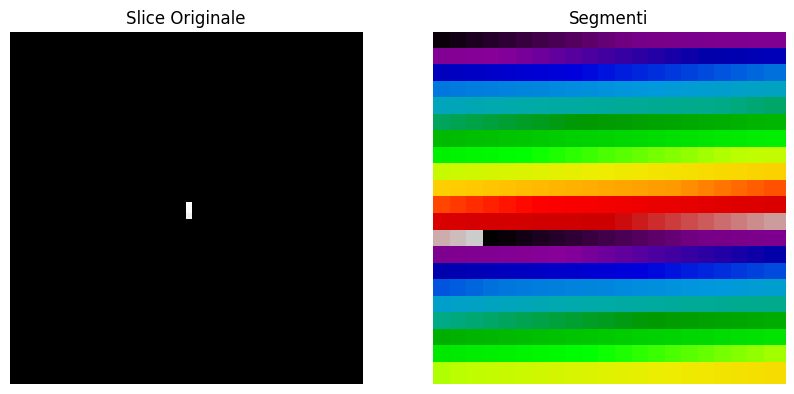

ValueError: could not broadcast input array from shape (64,64) into shape (512,512)

In [40]:
# Percorsi delle cartelle
pazienti_dir = 'C:\\Users\\bsbar\\Desktop\\pazienti_nrrd'
roi_dir = 'C:\\Users\\bsbar\\Desktop\\Tesi\\ROI'

# Cartelle da saltare
cartelle_da_saltare = ['19', '40', '88', '150', '193']

# Lista per i vettori delle features e i nomi dei pazienti
feature_vectors = []
patient_names = []
segmenti_numeri = []
dimension_mismatch = []

# Imposta l'estrattore radiomico
estrattore = featureextractor.RadiomicsFeatureExtractor()

# Funzione per estrarre le features da ciascun segmento
def estrai_features_segmenti(segmenti, volume_3d, maschera):
    feature_vectors = []
    segmenti_successo = []
    feature_names = None
    
    unique_segments = np.unique(segmenti)
    
    for segment in unique_segments:
        if segment == 0:
            continue
        
        segment_mask = (segmenti == segment)
        if np.any(segment_mask):
            segment_volume = np.where(segment_mask, volume_3d, 0)
            segment_masquer = np.where(segment_mask, maschera, 0)
            
            sitk_segment_volume = numpy_to_sitk(segment_volume)
            sitk_segment_masquer = numpy_to_sitk(segment_masquer)
            
            try:
                results = estrattore.execute(sitk_segment_volume, sitk_segment_masquer)
                if feature_names is None:
                    feature_names = list(results.keys())
                    
                feature_vector = [results.get(key, np.nan) for key in feature_names]
                feature_vectors.append(feature_vector)
                segmenti_successo.append(segment)
                
            except ValueError as e:
                print(f"Errore durante l'estrazione delle features per il segmento {segment}: {e}")
                continue

    return feature_vectors, segmenti_successo, feature_names

# Codice per processare i pazienti
for paziente in sorted(os.listdir(pazienti_dir)):
    if paziente in cartelle_da_saltare:
        print(f"Saltando paziente: {paziente}")
        continue

    print(f"Processando paziente: {paziente}")
    
    immagine_file = trova_nrrd_file(os.path.join(pazienti_dir, paziente))
    maschera_file = trova_nrrd_file(os.path.join(roi_dir, paziente))
    
    if immagine_file and maschera_file:
        volume_placca = carica_volume_paziente(os.path.join(pazienti_dir, paziente))
        maschera_placca = carica_volume_paziente(os.path.join(roi_dir, paziente))
        
        if volume_placca.shape == maschera_placca.shape:
            if len(volume_placca.shape) == 4:
                volume_placca = np.squeeze(volume_placca, axis=-1)
                maschera_placca = np.squeeze(maschera_placca, axis=-1)

            if volume_placca.shape[2] != 512:
                volume_placca = riduci_slice(volume_placca)
                maschera_placca = riduci_slice(maschera_placca)

            # Segmenta la placca
            segmenti = segmenta_placca(volume_placca, maschera_placca)
            
            # Visualizza una sezione del volume segmentato
            visualizza_segmenti(segmenti, volume_placca)
            
        else:
            print(f"Dimensioni non corrispondenti per il paziente {paziente}")
    else:
        print(f"File mancanti per il paziente {paziente}")

# Crea un DataFrame e salva come CSV
df = pd.DataFrame(feature_vectors, columns=feature_names)
df.insert(0, 'paziente', patient_names)
df.insert(1, 'segmento', segmenti_numeri)

# Salva il DataFrame in un file CSV
#df.to_csv('features_radiomiche_segmenti.csv', index=False)

## Salvataggio

In [6]:

# Carica il file CSV
file_path = 'features_radiomiche_blocchi.csv'
df = pd.read_csv(file_path)

# Stampa tutti i nomi delle colonne
print("Nomi delle colonne:")
print(df.columns.tolist())

# Specifica i nomi delle colonne da eliminare
colonne_da_eliminare = ['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass']  # Sostituisci con i nomi reali delle colonne da eliminare

# Elimina le colonne specificate
df = df.drop(columns=colonne_da_eliminare)

# Ordina il DataFrame in base alla prima colonna per numero in ordine crescente
df_sorted = df.sort_values(by=df.columns[0])

# Salva il DataFrame ordinato in un nuovo file CSV
df_sorted.to_csv('features_blocchi_nuove_16.csv', index=False)


Nomi delle colonne:
['paziente', 'blocco', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'origin

In [25]:
import csv

# Ordina i pazienti in base al loro nome numerico
patient_names_sorted, feature_vectors_sorted = zip(*sorted(zip(patient_names, feature_vectors), key=lambda x: int(x[0])))
feature_names = [key for key, value in results.items() if isinstance(value, (float, int, np.ndarray))]


# Salva le features e i nomi dei pazienti in un file CSV
output_csv = 'features_radiomiche_blocchi.csv'
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=';')  # Usa il delimitatore punto e virgola

    # Scrivi l'intestazione: la prima colonna è "Paziente" e le altre colonne rappresentano le features
    writer.writerow(['Paziente'] + feature_names)

    # Scrivi i dati: il nome del paziente e le sue features
    for name, features in zip(patient_names_sorted, feature_vectors_sorted):
        writer.writerow([name] + list(features))

print(f'File CSV salvato come {output_csv}')

NameError: name 'results' is not defined

## Da Provare

Blocchi Sovrapposti (Overlapping Blocks):Utilizza una finestra mobile che si sovrappone parzialmente tra i blocchi. Questo è particolarmente utile se la placca è piccola e non riempie completamente i blocchi di dimensioni standard. L'overlapping aiuta a garantire che nessuna parte della placca venga trascurata.
Adaptive Windowing:

Finestra Adattativa: Anziché usare blocchi di dimensioni fisse, puoi utilizzare finestre adattative che si adattano alle dimensioni della placca. Ad esempio, puoi estrarre blocchi di dimensioni variabili che siano abbastanza grandi da contenere la placca, ma non troppo grandi da includere troppo background.
Segmentation and Bounding Box Extraction:

Bounding Box: Segmenta il volume in base alla ROI e applica una bounding box attorno alla placca. Successivamente, estrai blocchi 3D di dimensioni adeguate attorno a questa bounding box. Se la placca è molto piccola, puoi espandere leggermente la bounding box per garantire che il blocco contenga la placca e una certa area circostante.
Grid Search with Padding:

Ricerca a Griglia con Padding: Suddividi il volume in blocchi utilizzando una griglia regolare ma includi un padding extra intorno alla placca. Questo significa che i blocchi saranno leggermente più grandi per garantire che la placca sia ben inclusa in uno dei blocchi.
Dynamic Slicing:

Slicing Dinamico: Se la placca è molto piccola, potresti considerare di estrarre slice multiple attorno alla placca e combinarle per formare un blocco 3D. Ad esempio, estrai le slice immediatamente sopra e sotto la placca e poi aggregale per creare un blocco che contenga la placca e un'area circostante.
Voxel-Based Extraction:

Estrazione Basata sui Voxel: Analizza i voxel che appartengono alla placca e poi crea blocchi basati su questi voxel. Puoi estrarre solo i voxel di interesse e poi costruire blocchi 3D attorno a questi voxel specifici.
Resampling e Scaling:

Risoluzione Adatta: Se i blocchi sono troppo grandi rispetto alla placca, considera di fare un resampling del volume per aumentare la risoluzione e ridurre le dimensioni dei blocchi. Questo può aiutare a garantire che la placca venga inclusa in modo più dettagliato all'interno dei blocchi.